<a href="https://colab.research.google.com/github/p33ves/CMPT726-ML-Project/blob/main/Passive_Customer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recursive Feature Selection using Gradient based and Tree based Estimators 

In [ ]:
pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 5.9MB/s 
     |████████████████████████████████| 6.8MB 26.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [46]:
data = pd.read_csv('https://raw.githubusercontent.com/p33ves/CMPT726-ML-Project/main/processed_datasets/profile_features.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.sample(10)

,gender,age,cust_id,became_member_on,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,Total transaction,offer completed_via_email,offer completed_via_social,offer completed_via_mobile,offer completed_via_web,offer completed bogo count,offer completed discount count,offer received_via_email,offer received_via_social,offer received_via_mobile,offer received_via_web,offer received bogo count,offer received discount count,offer received informational count,offer viewed_via_email,offer viewed_via_social,offer viewed_via_mobile,offer viewed_via_web,offer viewed bogo count,offer viewed discount count,offer viewed informational count,Total transaction amount,avg_difficulty,avg_duration,total_reward_received,total_reward_defined,total_view_ratio,total_completion_ratio,avg_transaction_amt,transactions_per_membership_days,customer_type
13567,M,63,4b5fb27e891149cba6e54cccc18f4526,2018-03-01,58000.0,1001,1.0,5.0,3.0,5.0,1.0,0.0,1.0,1.0,0.0,1.0,5.0,3.0,4.0,4.0,3.0,2.0,0.0,3.0,3.0,3.0,2.0,3.0,0.0,0.0,20.25,10.000000,154.666667,2.0,32.0,0.60,0.2,4.05,0.004995,passive
2483,M,66,3ab73b41e2ac4e67bb20be75543c1d78,2016-01-18,40000.0,1774,6.0,6.0,3.0,16.0,6.0,2.0,4.0,6.0,1.0,5.0,6.0,2.0,4.0,6.0,1.0,5.0,0.0,3.0,2.0,3.0,3.0,1.0,2.0,0.0,149.06,11.666667,192.000000,21.0,21.0,0.50,1.0,9.32,0.009019,passive
1163,F,48,2d5b8dfaa968465b89949bc63fd0cf6b,2015-08-13,93000.0,1932,4.0,4.0,3.0,10.0,4.0,2.0,4.0,4.0,1.0,3.0,4.0,2.0,4.0,4.0,1.0,3.0,0.0,3.0,2.0,3.0,3.0,0.0,3.0,0.0,245.27,8.272727,187.636364,12.0,12.0,0.75,1.0,24.53,0.005176,passive
8497,M,66,c9efe52c3dd44130a07481a0f6274e10,2017-03-05,68000.0,1362,2.0,4.0,4.0,13.0,2.0,1.0,1.0,2.0,1.0,1.0,4.0,2.0,3.0,3.0,1.0,1.0,2.0,4.0,2.0,3.0,3.0,1.0,1.0,2.0,62.39,9.000000,141.600000,15.0,15.0,1.00,0.5,4.80,0.009545,active
7879,F,91,5aff0af6169e476692a5a68648e9f9cc,2017-09-06,64000.0,1177,0.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,3.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,2.01,6.500000,156.000000,0.0,18.0,0.50,0.0,2.01,0.000850,passive
795,F,64,393833837038441aa4eb172c1220ad2a,2017-06-04,59000.0,1271,4.0,4.0,4.0,8.0,4.0,3.0,4.0,4.0,2.0,2.0,4.0,3.0,4.0,4.0,2.0,2.0,0.0,4.0,3.0,4.0,4.0,2.0,2.0,0.0,142.64,8.750000,192.000000,19.0,19.0,1.00,1.0,17.83,0.006294,active
3275,F,79,ce1579c557c14f7785869dc80638bc0f,2016-05-24,72000.0,1647,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,10.000000,168.000000,0.0,15.0,0.00,0.0,0.00,0.000000,passive
11098,F,82,c63334d18bcd46568118300b1aa97df7,2017-12-14,82000.0,1078,4.0,4.0,4.0,12.0,4.0,4.0,4.0,3.0,3.0,1.0,4.0,4.0,4.0,3.0,3.0,1.0,0.0,4.0,4.0,4.0,3.0,3.0,1.0,0.0,278.15,9.250000,144.000000,33.0,33.0,1.00,1.0,23.18,0.011132,active
1168,M,63,f7465d18ba7f4e43b99ccabf141d421d,2013-09-21,47000.0,2623,3.0,5.0,1.0,11.0,3.0,1.0,3.0,3.0,0.0,3.0,5.0,1.0,4.0,5.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,33.23,11.111111,200.000000,6.0,13.0,0.20,0.6,3.02,0.004194,passive
6605,F,75,3ca81d378ae04fa0b597aa70ef98c403,2018-01-17,97000.0,1044,2.0,5.0,3.0,7.0,2.0,2.0,2.0,2.0,2.0,0.0,5.0,4.0,5.0,3.0,2.0,0.0,3.0,3.0,3.0,3.0,2.0,2.0,0.0,1.0,146.77,3.000000,103.200000,10.0,10.0,0.60,0.4,20.97,0.006705,passive


In [47]:
# define dataset
gen_split = pd.get_dummies(data['gender'], prefix='is_')
data['income_in_k'] = data['income']/1000
data = pd.concat([data, gen_split], axis=1)
data = data.drop('income', axis=1)
data.drop('gender', axis=1, inplace=True)
data.sample(10)

,age,cust_id,became_member_on,days_as_member,Total offer completed,Total offer received,Total offer viewed,Total transaction,offer completed_via_email,offer completed_via_social,offer completed_via_mobile,offer completed_via_web,offer completed bogo count,offer completed discount count,offer received_via_email,offer received_via_social,offer received_via_mobile,offer received_via_web,offer received bogo count,offer received discount count,offer received informational count,offer viewed_via_email,offer viewed_via_social,offer viewed_via_mobile,offer viewed_via_web,offer viewed bogo count,offer viewed discount count,offer viewed informational count,Total transaction amount,avg_difficulty,avg_duration,total_reward_received,total_reward_defined,total_view_ratio,total_completion_ratio,avg_transaction_amt,transactions_per_membership_days,customer_type,income_in_k,is__F,is__M,is__O
3175,82,f5ae5f22cbbd45edb721587c2f845a00,2018-05-25,916,2.0,5.0,5.0,6.0,2.0,1.0,2.0,2.0,0.0,2.0,5.0,3.0,5.0,4.0,0.0,3.0,2.0,5.0,3.0,5.0,4.0,0.0,3.0,2.0,55.68,5.916667,152.000000,5.0,7.0,1.00,0.40,9.28,0.006550,active,44.0,0,1,0
9044,21,cf26038174b4410f83d5cc1ada658948,2018-07-17,863,1.0,5.0,4.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,4.0,5.0,3.0,1.0,1.0,3.0,4.0,4.0,4.0,2.0,1.0,1.0,2.0,21.00,2.900000,108.000000,5.0,8.0,0.80,0.20,4.20,0.005794,active,42.0,0,1,0
13534,62,a73dd52818714d8d9b36e02affd56a59,2018-06-21,889,0.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.68,5.000000,136.000000,0.0,10.0,0.50,0.00,0.23,0.003375,passive,45.0,0,1,0
6070,80,12e0c95d8db54ee48800073d5b0a1269,2018-04-17,954,3.0,5.0,4.0,6.0,3.0,2.0,2.0,2.0,1.0,2.0,5.0,2.0,3.0,4.0,1.0,3.0,1.0,4.0,2.0,3.0,3.0,1.0,2.0,1.0,133.17,11.666667,198.000000,17.0,22.0,0.80,0.60,22.19,0.006289,active,72.0,0,1,0
1916,24,e3534fe180e14735b2199bffefb1887f,2016-04-08,1693,1.0,4.0,3.0,16.0,1.0,1.0,1.0,1.0,1.0,0.0,4.0,3.0,3.0,3.0,3.0,1.0,0.0,3.0,3.0,3.0,2.0,3.0,0.0,0.0,42.37,9.375000,147.000000,5.0,30.0,0.75,0.25,2.65,0.009451,passive,59.0,0,1,0
12950,65,69519c33ae124ef9bb84135555a33452,2016-08-24,1555,6.0,6.0,6.0,17.0,6.0,2.0,4.0,6.0,1.0,5.0,6.0,2.0,4.0,6.0,1.0,5.0,0.0,6.0,2.0,4.0,6.0,1.0,5.0,0.0,346.73,12.500000,216.000000,21.0,21.0,1.00,1.00,20.40,0.010932,active,80.0,1,0,0
8229,25,de5a7b09cf5140c9a5b2827a7e04c808,2014-07-17,2324,4.0,5.0,3.0,15.0,4.0,2.0,4.0,4.0,2.0,2.0,5.0,2.0,4.0,5.0,2.0,3.0,0.0,3.0,2.0,3.0,3.0,1.0,2.0,0.0,67.40,8.000000,162.000000,15.0,20.0,0.60,0.80,4.49,0.006454,passive,53.0,1,0,0
3254,85,735f456dacaa4734a3862d099d26c683,2018-04-05,966,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,4.0,4.0,4.0,3.0,2.0,2.0,0.0,4.0,4.0,4.0,3.0,2.0,2.0,0.0,92.72,8.000000,174.000000,20.0,20.0,1.00,1.00,23.18,0.004141,active,80.0,1,0,0
1165,40,4e0f4afd7d524c049f2829c9ad611ab0,2016-09-11,1537,2.0,4.0,4.0,10.0,2.0,1.0,2.0,2.0,1.0,1.0,4.0,3.0,4.0,2.0,1.0,1.0,2.0,4.0,3.0,4.0,2.0,1.0,1.0,2.0,201.78,4.500000,151.200000,7.0,7.0,1.00,0.50,20.18,0.006506,active,79.0,0,1,0
62,51,f44b44b53c0548d5b27c812fda4c358a,2015-12-31,1792,3.0,6.0,4.0,20.0,3.0,3.0,3.0,3.0,1.0,2.0,6.0,4.0,4.0,5.0,2.0,4.0,0.0,4.0,3.0,3.0,4.0,1.0,3.0,0.0,75.96,11.153846,206.769231,9.0,29.0,0.67,0.50,3.80,0.011161,passive,41.0,0,1,0


## Finding set of correlated features

In [48]:
correlated_features = set()
correlation_matrix = data[['is__F', 'is__M', 'is__O', 'age', 'income_in_k', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt', 'transactions_per_membership_days', 'days_as_member']].corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
correlated_features

{'is__M'}

## Set X as Input features and y as target label

In [49]:
X = data[['is__F', 'is__O', 'age', 'income_in_k', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt', 'transactions_per_membership_days', 'days_as_member']]
y = data['customer_type']

In [50]:
#Changing active to 1 and passive to 0 to get f1 score
y = y.replace(to_replace='active', value= 0)
y = y.replace(to_replace='passive', value= 1)

## Split Data to Training and Testing Data

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

In [52]:
#Print the shape of training and test data
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (11118, 9)
X_test:  (3707, 9)


## Running RFECV

In [53]:
#RFECV automatically selects the number of features
#Checking with Decision Tree Classifier model
model = DecisionTreeClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='f1')
pipeline = Pipeline(steps=[('s',rfecv),('m',model)])

pipeline.fit(X_train, y_train)
print('Columns {}'.format(X_train.columns))
print('Optimal number of features: {}'.format(rfecv.n_features_))
print('Feature selection array: ', rfecv.support_)
print('Feature Ranking: ',rfecv.ranking_)

Columns Index(['is__F', 'is__O', 'age', 'income_in_k', 'avg_difficulty',
       'avg_duration', 'avg_transaction_amt',
       'transactions_per_membership_days', 'days_as_member'],
      dtype='object')
Optimal number of features: 8
Feature selection array:  [ True False  True  True  True  True  True  True  True]
Feature Ranking:  [1 2 1 1 1 1 1 1 1]


In [54]:
#evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
print('F1 Score: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

F1 Score: 0.689 (0.011)


In [55]:
#RFECV automatically selects the number of features
#Checking with Decision Tree Classifier model
X_no_inc = X_train.drop('income_in_k', axis=1)
model = DecisionTreeClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='f1')
pipeline = Pipeline(steps=[('s',rfecv),('m',model)])

pipeline.fit(X_no_inc, y_train)
print('Columns {}'.format(X_no_inc.columns))
print('Optimal number of features: {}'.format(rfecv.n_features_))
print('Feature selection array: ', rfecv.support_)
print('Feature Ranking: ',rfecv.ranking_)

Columns Index(['is__F', 'is__O', 'age', 'avg_difficulty', 'avg_duration',
       'avg_transaction_amt', 'transactions_per_membership_days',
       'days_as_member'],
      dtype='object')
Optimal number of features: 7
Feature selection array:  [ True False  True  True  True  True  True  True]
Feature Ranking:  [1 2 1 1 1 1 1 1]


In [56]:
#evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_no_inc, y_train, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
print('F1 Score: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

F1 Score: 0.681 (0.015)


## Plotting the RFECV curve for the model with best accuracy

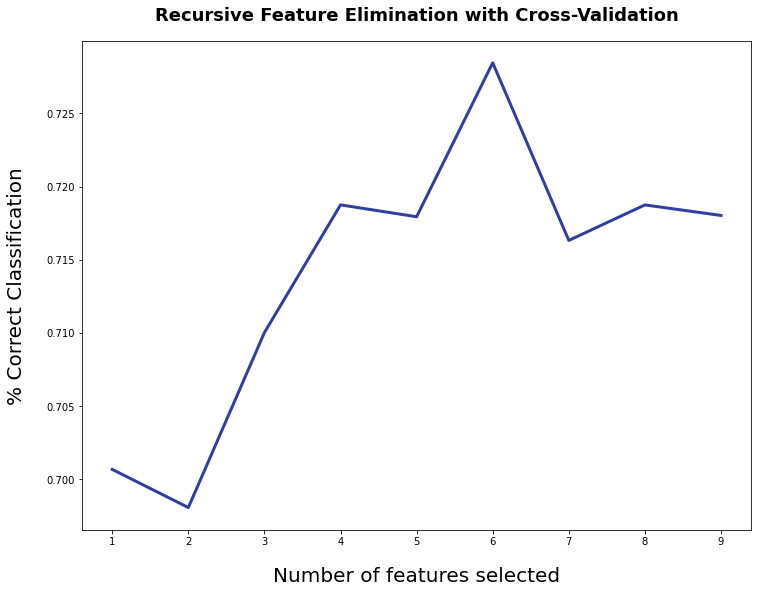

In [ ]:
plt.figure(figsize=(12, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=20, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=20, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [ ]:
# Least important features

print(np.where(rfecv.support_ == False)[0])

#Dropping the non-required features from training and test data
X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_test.drop(X_test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[0 1 2]


In [ ]:
#Print features and feature importance
print("Features: ", X_train.columns)
print("Feature Importance: ", rfecv.estimator_.feature_importances_)

Features:  Index(['income_in_k', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt',
       'transactions_per_membership_days', 'days_as_member'],
      dtype='object')
Feature Importance:  [0.09078995 0.11987939 0.11549176 0.33867724 0.21099512 0.12416654]


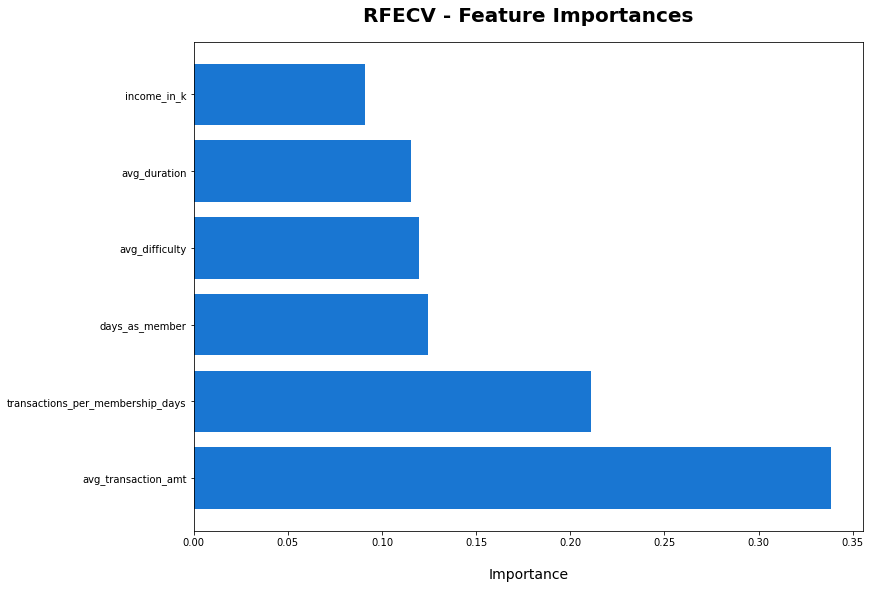

In [ ]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(12, 9))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## Check if data is balanced

In [ ]:
y_train.value_counts()

active     7240
passive    3878
Name: customer_type, dtype: int64

In [ ]:
#Find percentage distribution
round((y_train.value_counts()/y_train.count())*100,2)

active     65.12
passive    34.88
Name: customer_type, dtype: float64

#### The target classes are imbalanced!

### SMOTE

In [ ]:
#Applying SMOTE to oversample the minority class before modeling
oversample = SMOTE(random_state = 101)
X_oversample, y_oversample = oversample.fit_resample(X_train, y_train)

#converting arrays back to Dataframe and Series
X_train = pd.DataFrame(X_oversample, columns=X_train.columns)
y_train = pd.Series(y_oversample, name='y_train')

In [ ]:
#check percentage distribution
round((y_train.value_counts()/y_train.count())*100,2)

active     50.0
passive    50.0
Name: y_train, dtype: float64

In [ ]:
y_train.value_counts()

active     7240
passive    7240
Name: y_train, dtype: int64

In [ ]:
y_train

0        1
1        0
2        1
3        1
4        0
        ..
14475    0
14476    0
14477    0
14478    0
14479    0
Name: y_train, Length: 14480, dtype: int64

## Modeling and Prediction

In [ ]:
#Use GridSearchCV to fit selected classifiers to compare the efficiencies of different models
def train_classifier(classifier, hyperparameters, X, y): 
    gridsearch = GridSearchCV(estimator=classifier, param_grid = hyperparameters, cv=5, verbose=1, scoring = 'f1')
    model_train = gridsearch.fit(X, y)
    print(classifier.__class__.__name__)
    print("Mean Accuracy:", round(model_train.score(X, y),4))
    print("F1: ",gridsearch.best_score_)
    return gridsearch.best_estimator_

In [ ]:
# Initialize classification algorithms
# LogisticRegression
lor = LogisticRegression(random_state=42)
lor_est = train_classifier(lor,{}, X_train, y_train)

# RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc_est = train_classifier(rfc,{}, X_train, y_train)

# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=42) 
abc_est = train_classifier(abc,{}, X_train, y_train)

# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42) 
gbc_est = train_classifier(gbc,{}, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


LogisticRegression
Mean Accuracy: 0.7122
F1:  0.7078945274546073
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.7s finished


RandomForestClassifier
Mean Accuracy: 1.0
F1:  0.8154611186955144
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished


AdaBoostClassifier
Mean Accuracy: 0.7746
F1:  0.7683743410204935
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.9s finished


GradientBoostingClassifier
Mean Accuracy: 0.803
F1:  0.787357177526406


#### Highest f1 score is obtained for RandomForestClassifier

## Fine Tuning the Model

### Fine tuning RandomForestClassifier and GradientBosstingClassifier with the top set of F1 scores

In [ ]:
#Tuning the RandomForestClassifier with hyperparameters to improve the accuracy score
hyperparameters = {'n_estimators': [1200],#[100, 120, 300, 500, 800, 1200], #sets the number of decision trees to be used in the forest
                  'max_depth': [25]#[5, 8, 15, 25, 30, None], #sets the max depth of the tree
                  #'min_samples_split': [1,2,5,10,15,100], #The minimum number of samples needed before a split
                  #'min_samples_leaf': [1,2,5,10] #The minimum number of samples needed to create a leaf (decision) node
             }

rfc = RandomForestClassifier(random_state=42)
rfc_best_est = train_classifier(rfc, hyperparameters, X_train, y_train)
print(rfc_best_est)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished


RandomForestClassifier
Mean Accuracy: 1.0
F1:  0.8190070925988147
RandomForestClassifier(max_depth=25, n_estimators=1200, random_state=42)


In [ ]:
#Feature importances given by the best estimate RandomForestClassfier
rfc_best_est.feature_importances_

array([0.1215825 , 0.10890501, 0.11246846, 0.30164282, 0.20232304,
       0.15307817])

In [ ]:
#Tuning the GradientBoostingClassifier with hyperparameters to improve the accuracy score
#learning_rate; default=0.1; shrinks the contribution of each tree by learning_rates
lr = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

#n_estimators, default=100, number of boosting stages to perform
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

#max_depth, default=3, maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree
max_depths = [5, 8, 15, 25, 30, None]

#min_samples_split, default=2, The minimum number of samples required to split an internal node
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)

#min_samples_leaf, default=1,The minimum number of samples required to be at a leaf node.
min_samples_leaf=np.linspace(0.1, 0.5, 5, endpoint=True)

#max_features{‘auto’, ‘sqrt’, ‘log2’}, default=None, The number of features to consider when looking for the best split:
max_features = list(range(1,X_train.shape[1]))

gb_tuned = GradientBoostingClassifier(random_state=42)
hyperparameters = {'learning_rate': [0.5], 'n_estimators': [200], 'max_depth': [15]}#, 'min_samples_split': min_samples_split, 'min_samples_leaf':min_samples_leaf, 'max_features':max_features}   
gb_best_est = train_classifier(gb_tuned, hyperparameters, X_train, y_train)
print(gb_best_est)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished


GradientBoostingClassifier
Mean Accuracy: 1.0
F1:  0.8278980691458615
GradientBoostingClassifier(learning_rate=0.5, max_depth=15, n_estimators=200,
                           random_state=42)


### After fine-tuning GradientBoostClassifier seems to have a higher f1 score than RandomForestClassifier!

## Prediction and Performance of Classifiers

In [ ]:
#Print the shape of test data
print(X_test.shape)
print(y_test.shape)

(3707, 6)
(3707,)


### GradientBoostingClassifier

In [ ]:
#Passing the test data to the GradientBoostingClassifier estimator
y_pred_gbc = gb_best_est.predict(X_test)
y_pred_gbc

array([1, 1, 0, ..., 1, 1, 1])

#### Classification Report with F1 score

In [ ]:
print(classification_report(y_test, y_pred_gbc))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69      1310
           1       0.82      0.86      0.84      2397

    accuracy                           0.79      3707
   macro avg       0.77      0.76      0.77      3707
weighted avg       0.79      0.79      0.79      3707



#### Confusion Matrix

[[0.65954198 0.34045802]
 [0.13642053 0.86357947]]


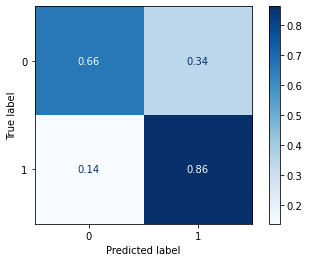

In [ ]:
disp = plot_confusion_matrix(gb_best_est, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
print(disp.confusion_matrix)

plt.show()

#### F1 Scores have better values for test data!

### RandomForestClassifier

In [ ]:
#Passing the test data to the RandomForestClassifier estimator
y_pred_rfc = rfc_best_est.predict(X_test)
y_pred_rfc

array([1, 1, 1, ..., 1, 1, 1])

#### Classification Report with F1 score





In [ ]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1310
           1       0.84      0.86      0.85      2397

    accuracy                           0.80      3707
   macro avg       0.78      0.78      0.78      3707
weighted avg       0.80      0.80      0.80      3707



#### Confusion Matrix

[[0.69465649 0.30534351]
 [0.14392991 0.85607009]]


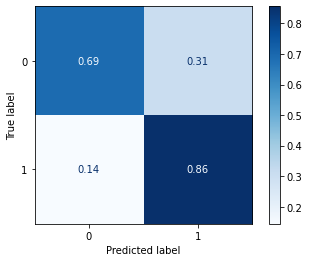

In [ ]:
disp = plot_confusion_matrix(rfc_best_est, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
print(disp.confusion_matrix)

plt.show()

### AdaBoostClassifier

In [ ]:
#Passing the test data to the AdaBoostClassifier estimator
y_pred_abc = abc_est.predict(X_test)
y_pred_abc

array([1, 1, 1, ..., 0, 0, 1])

#### Classification Report with F1 score





In [ ]:
print(classification_report(y_test, y_pred_abc))

              precision    recall  f1-score   support

           0       0.67      0.70      0.69      1310
           1       0.83      0.81      0.82      2397

    accuracy                           0.77      3707
   macro avg       0.75      0.76      0.75      3707
weighted avg       0.78      0.77      0.77      3707



#### Confusion Matrix

[[0.70152672 0.29847328]
 [0.1864831  0.8135169 ]]


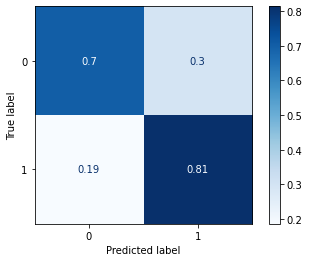

In [ ]:
disp = plot_confusion_matrix(abc_est, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
print(disp.confusion_matrix)

plt.show()

### Logistic Regression

In [ ]:
#Passing the test data to the Logistic Regressor
y_pred_lor = lor_est.predict(X_test)
y_pred_lor

array([1, 1, 1, ..., 0, 0, 0])

#### Classification Report with F1 score





In [ ]:
print(classification_report(y_test, y_pred_lor))

              precision    recall  f1-score   support

           0       0.57      0.65      0.60      1310
           1       0.79      0.73      0.76      2397

    accuracy                           0.70      3707
   macro avg       0.68      0.69      0.68      3707
weighted avg       0.71      0.70      0.70      3707



#### Confusion Matrix 

[[0.6480916  0.3519084 ]
 [0.27242386 0.72757614]]


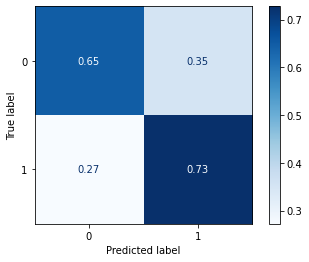

In [ ]:
disp = plot_confusion_matrix(lor_est, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
print(disp.confusion_matrix)

plt.show()